# Filtering for Cells with Ideal Combination of Guides 

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  **Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.**
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.

4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest 

    A. UMAPs 
    
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773_)
8. Differential Expression analysis.

    A. Find the shared P1 and P2 genes. 

    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
    
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment



In CRISPR screening, it isn't enough to just see a guide; you need to know if the signal is strong enough to be confident.

- Read vs. UMI: The code calculates Coverage by dividing the read_count by the UMI_count.

- The Logic: High coverage suggests that the UMI was sequenced multiple times, providing high confidence that the guide was actually present in that droplet and isn't just background noise or sequencing error.

In [19]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from upsetplot import plot
import warnings 
import os 

# Set the color for the histogram
color1 = '#4d00c7'
palecolor1 = "#b366ff"
color2 = '#da3c07'
palecolor2 = "#ff8954"
color3 = '#05d3d3'
color4 = '#c6c7c5'
color5 = 'black'

# Create the color palette
palette = sns.color_palette([color1, color2, color3, color4, color5])

# Define the columns of interest
columns_interest = ['cell_barcode', 'correct_num_guides', 'correct_partner', 'same_promotertype', 'same_gene']
warnings.filterwarnings('ignore')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28365


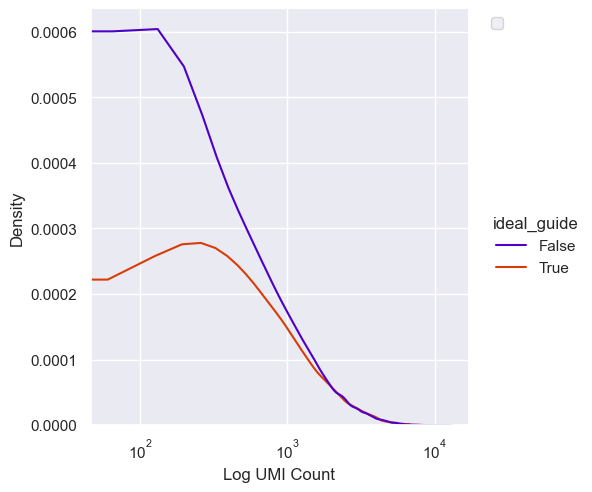

In [ ]:

# Load cell identities data
cell_identities = pd.read_csv("../../cellranger_output/cell_identities.csv")

# Extract guide target from guide identity
cell_identities["guide_target"] = (
    cell_identities["guide_identity"].str.split("_").str[0].str.split("sg").str[1]
)
cell_identities["guide_target"] = np.where(
    cell_identities["guide_target"].str.startswith("non"), "NegCtrl3b", cell_identities["guide_target"]
)
cell_identities.loc[cell_identities["guide_target"] == "NegCtrl3b", "guide_target"] = "Negative_Control"

# Format table of promoter type
cell_identities["promoter_type"] = (
    cell_identities["guide_identity"].str.split("_").str[1].str.split("sg").str[0].str[:2]
)
cell_identities["promoter_type"] = np.where(
    cell_identities["promoter_type"].isin(["MP", "AP"]),
    cell_identities["promoter_type"],
    "Control"
)
cell_identities["guide_target"] = np.where(
    (cell_identities["promoter_type"] == "Control") & (cell_identities["guide_target"] != "Negative_Control"),
    cell_identities["guide_target"].str[:-1],
    cell_identities["guide_target"]
)

# Count the number of unique guides per barcode
num_guides = (
    cell_identities.reset_index()[["cell_barcode", "guide_identity"]]
    .drop_duplicates()
    ["cell_barcode"].value_counts()
    .rename("num_guides")
    .to_frame()
)

# Merge num_guides with cell_identities
temp_indexed = cell_identities.set_index("cell_barcode")
cell_identities = num_guides.merge(temp_indexed, left_index=True, right_index=True).reset_index()

# Check if the same gene is present
same_gene = cell_identities.groupby("cell_barcode")["guide_target"].nunique() == 1
cell_identities = cell_identities.merge(
    same_gene.rename("same_gene"), left_on="cell_barcode", right_index=True
)

# Check if the same promoter type is present
same_promoter_type = cell_identities.groupby("cell_barcode")["promoter_type"].nunique() == 1
cell_identities = cell_identities.merge(
    same_promoter_type.rename("same_promotertype"), left_on="cell_barcode", right_index=True
)

# Extract position letter
cell_identities["sgRNA_pos"] = cell_identities["guide_identity"].str[-1]

# Check if A and B or C and D are present
for pair, col_name in [("AB", "AorB"), ("CD", "CorD")]:
    subset = frozenset(pair)
    check_pair = cell_identities.groupby("cell_barcode")["sgRNA_pos"].apply(subset.issubset)
    cell_identities = cell_identities.merge(check_pair.rename(col_name), left_on="cell_barcode", right_index=True)

# Determine correct partner and ideal guide
cell_identities["correct_partner"] = (
    (cell_identities["CorD"] | cell_identities["AorB"]) |
    (cell_identities["guide_target"] == "Negative_Control")
)
cell_identities["ideal_guide"] = (
    cell_identities["correct_partner"] &
    cell_identities["same_promotertype"] &
    cell_identities["same_gene"] &
    (cell_identities["num_guides"] == 2)
)
cell_identities["correct_num_guides"] = cell_identities["num_guides"] == 2

# Plot UMI count distribution
sns.set(rc={'figure.figsize': (14.7, 7.27)})
palette = sns.color_palette([color1, color2])
sns.displot(x=cell_identities["UMI_count"], kind="kde", hue=cell_identities["ideal_guide"], palette=palette)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xscale("log")
plt.xlabel("Log UMI Count")
plt.show()


This is the most critical logic for this specific paper. The experiment uses a dual-guide strategy (targeting the same promoter with two different guides to ensure knockdown).

Filtering Criteria: To be considered an "Ideal Cell," a barcode must meet four strict criteria:

Correct Number: It must have exactly 2 unique guides.

Same Gene: Both guides must target the same gene.

Same Promoter Type: Both must target either the Major Promoter (MP) or the Alternative Promoter (AP).

Correct Partner (A/B or C/D): The library design uses specific pairs (e.g., guide A and guide B always go together). The code checks if the detected guides are the intended biological partners.

Number of unique cell barcodes:
28365


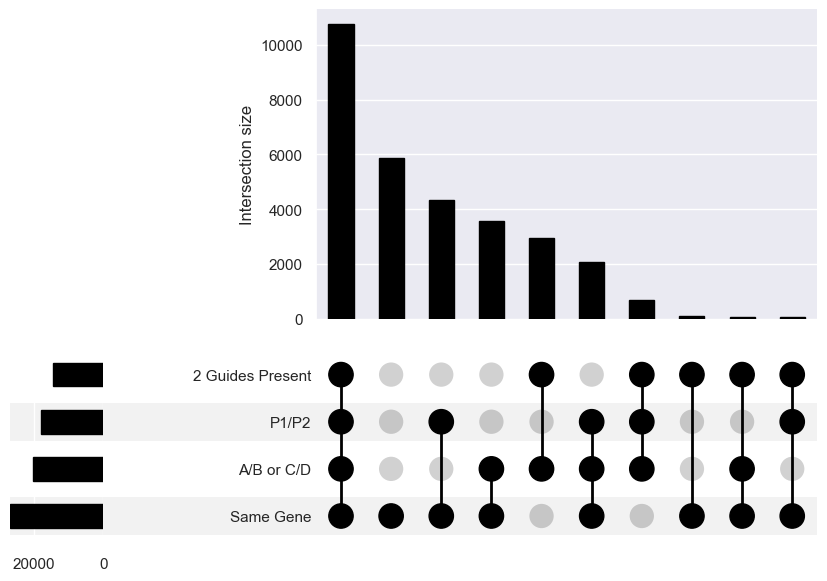

In [34]:
# Define the columns of interest
columns_interest = ['cell_barcode', 'correct_num_guides', 'correct_partner', 'same_promotertype', 'same_gene']

# Drop duplicate rows based on the columns of interest
plotpop = cell_identities[columns_interest].drop_duplicates()

# Update columns of interest to exclude 'cell_barcode'
columns_interest = ['correct_num_guides', 'correct_partner', 'same_promotertype', 'same_gene']

# Create a subset of the data with the updated columns of interest
subplotpop = plotpop[columns_interest]

# Rename the columns for better readability
subplotpop.columns = ["Same Gene", "P1/P2", "A/B or C/D", "2 Guides Present"]

# Plot the value counts of the subset data
plot(subplotpop.value_counts(), facecolor="black", orientation="horizontal", sort_by="cardinality", element_size=50)

print("Number of unique cell barcodes:")
print(cell_identities["cell_barcode"].nunique())

# Show the plot
plt.show()

What you see: It visualizes how many cells were discarded because they had the wrong number of guides, or guides targeting different genes.

The Result: Only the "Success" slice of the population (cells meeting all 4 criteria above) is saved into cell_identities_ideal.csv. This ensures the downstream differential expression analysis isn't "muddied" by cells with ambiguous perturbations.

In [22]:
#check if the file exists
if os.path.exists("../../cellranger_output/cell_identities_additional.csv"):
    cell_identities_add=pd.read_csv("../../cellranger_output/cell_identities_additional.csv")
else:
    cell_identities_add=cell_identities[['cell_barcode','guide_identity','read_count','UMI_count','coverage','gemgroup','good_coverage','number_of_cells']]
    cell_identities_add.to_csv("../../cellranger_output/cell_identities_additional.csv",index=None)
#ideal cell identity additional
if os.path.exists("../../cellranger_output/cell_identities_ideal_additional.csv"):
    cell_identites_ideal_add=pd.read_csv("../../cellranger_output/cell_identities_ideal_additional.csv")
else:
    cell_identites_ideal_add=cell_identities[cell_identities["ideal_guide"]==True]
#ideal cell identity
if os.path.exists("../../cellranger_output/cell_identities_ideal.csv"):
    cell_identites_ideal=pd.read_csv("../../cellranger_output/cell_identities_ideal.csv")
else:  
    cell_identites_ideal=cell_identities[['cell_barcode','guide_identity','read_count','UMI_count','coverage','gemgroup','good_coverage','number_of_cells']][cell_identites["ideal_guide"]==True]


The final section generates KDE (Kernel Density Estimate) and line plots comparing Ideal vs. Non-Ideal cells.

Log UMI Count: The code looks at the distribution of UMIs for the guides.

The Goal: You should see that "Ideal" cells (those with the correct dual guides) generally have higher UMI counts. If a cell has very few UMIs for a guide, the knockdown might not have been effective, so these plots serve as a final "sanity check" on the library's performance before looking at the transcriptome.

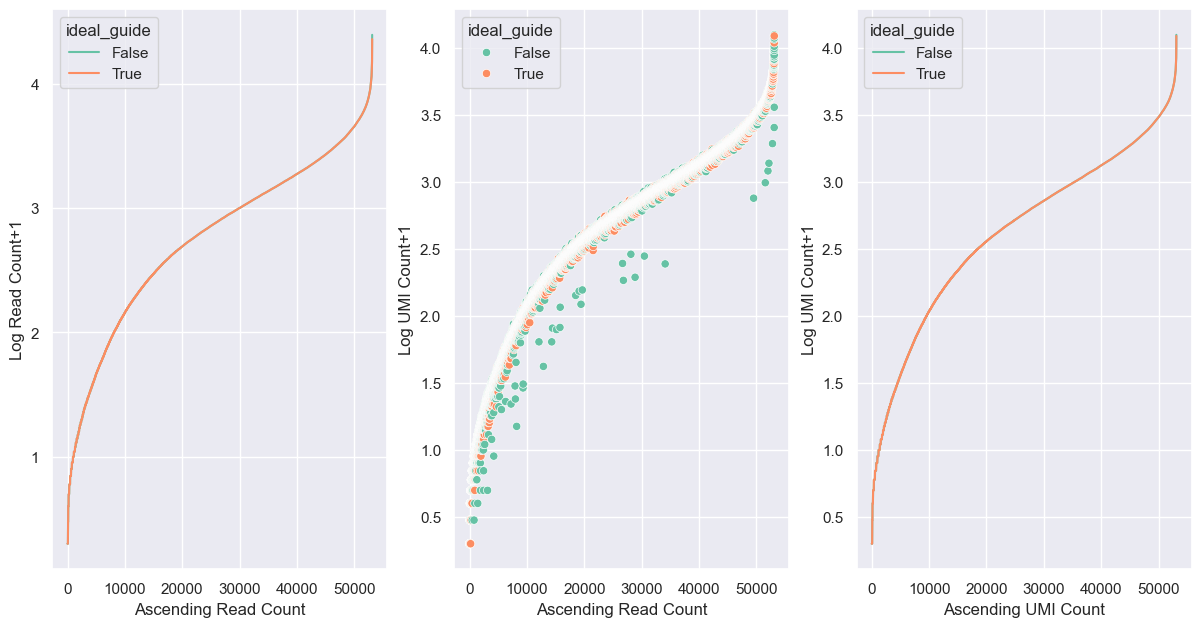

In [23]:
cell_identities["logread_count"]=np.log10(cell_identities["read_count"]+1)
cell_identities["logUMI_count"]=np.log10(cell_identities["UMI_count"]+1)
sns.set(rc={'figure.figsize':(14.7,7.27)})

fig, axs = plt.subplots(ncols=3)

#plot the number of reads per cell
cell_identities=cell_identities.sort_values("read_count")
# cell_identites=cell_identites.drop("level_0", axis=1)
cell_identities.reset_index(inplace=True)

sns.lineplot(x=cell_identities.index, y=cell_identities["logread_count"],palette="Set2", hue=cell_identities["ideal_guide"] , ax=axs[0])
axs[0].set_ylabel("Log Read Count+1")
axs[0].set_xlabel("Ascending Read Count")

sns.scatterplot(x=cell_identities.index, y=cell_identities["logUMI_count"],palette="Set2",hue=cell_identities["ideal_guide"] , ax=axs[1])
axs[1].set_ylabel("Log UMI Count+1")
axs[1].set_xlabel("Ascending Read Count")



#plot the number of reads per cell
cell_identites=cell_identities.sort_values("UMI_count")
cell_identites.reset_index(inplace=True)
sns.lineplot(x=cell_identites.index, y=cell_identites["logUMI_count"],palette="Set2",hue=cell_identites["ideal_guide"] ,ax=axs[2])
axs[2].set_ylabel("Log UMI Count+1")
axs[2].set_xlabel("Ascending UMI Count")

plt.show()
